# Gun Violence Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# gun violence data 2013-2018
#df_gun_violence = pd.read_csv('./dataset/gun-violence-data_01-2013_03-2018.csv')
df_gun_violence = pd.read_csv('https://media.githubusercontent.com/media/Cng000/Gun-violence-analysis/master/dataset/gun-violence-data_01-2013_03-2018.csv')

In [3]:
# mean annual household income (2016)
#df_income = pd.read_csv('./dataset/2016_mean_income_raw_data.csv', skiprows=2)
df_income = pd.read_csv('https://raw.githubusercontent.com/Cng000/Gun-violence-analysis/master/dataset/2016_mean_income_raw_data.csv', skiprows=2)

In [4]:
# population estimates
#df_state_populations = pd.read_csv('./dataset/population_estimates.csv', skiprows=1)
df_state_populations = pd.read_csv('https://raw.githubusercontent.com/Cng000/Gun-violence-analysis/master/dataset/population_estimates.csv', skiprows=1)

In [5]:
# NRA spending
df_nra_spending = pd.read_csv('https://raw.githubusercontent.com/Cng000/Gun-violence-analysis/master/dataset/nra_spending_115th_congress.csv', skiprows=1)
# US state codes (source, https://github.com/jasonong/List-of-US-States/blob/master/states.csv)
df_state_codes = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

### Gun Violence Analysis

In [6]:
df_gun_violence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 29 columns):
incident_id                    239677 non-null int64
date                           239677 non-null object
state                          239677 non-null object
city_or_county                 239677 non-null object
address                        223180 non-null object
n_killed                       239677 non-null int64
n_injured                      239677 non-null int64
incident_url                   239677 non-null object
source_url                     239209 non-null object
incident_url_fields_missing    239677 non-null bool
congressional_district         227733 non-null float64
gun_stolen                     140179 non-null object
gun_type                       140226 non-null object
incident_characteristics       239351 non-null object
latitude                       231754 non-null float64
location_description           42089 non-null object
longitude                    

In [7]:
df_gun_violence.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [8]:
# let's drop some columns
df_gun_violence.drop(['incident_id', 'address', 'incident_url', 'source_url', 'incident_url_fields_missing', 'latitude', 'location_description', 'longitude', 'notes', 'participant_name', 'participant_relationship', 'sources'], axis=1)

,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,n_guns_involved,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district
0,2013-01-01,Pennsylvania,Mckeesport,0,4,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN
1,2013-01-01,California,Hawthorne,1,3,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,62.0,35.0
2,2013-01-01,Ohio,Lorain,1,3,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,56.0,13.0
3,2013-01-05,Colorado,Aurora,4,0,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,40.0,28.0
4,2013-01-07,North Carolina,Greensboro,2,2,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,62.0,27.0
5,2013-01-07,Oklahoma,Tulsa,4,0,1.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Hom...",NaN,0::23||1::23||2::33||3::55,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,72.0,11.0
6,2013-01-19,New Mexico,Albuquerque,5,0,1.0,0::Unknown||1::Unknown,0::22 LR||1::223 Rem [AR-15],"Shot - Dead (murder, accidental, suicide)||Mas...",2.0,0::51||1::40||2::9||3::5||4::2||5::15,0::Adult 18+||1::Adult 18+||2::Child 0-11||3::...,0::Male||1::Female||2::Male||3::Female||4::Fem...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,10.0,14.0
7,2013-01-21,Louisiana,New Orleans,0,5,2.0,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,NaN,NaN,0::Male||1::Male||2::Male||3::Male||4::Male,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,93.0,5.0
8,2013-01-21,California,Brentwood,0,4,9.0,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,NaN,0::Teen 12-17||1::Teen 12-17||2::Teen 12-17||4...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,11.0,7.0
9,2013-01-23,Maryland,Baltimore,1,6,7.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,0::15,0::Teen 12-17||1::Adult 18+||2::Adult 18+||3::...,0::Male,0::Killed||1::Injured||2::Injured||3::Injured|...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,44.0


In [9]:
# extract year from date
df_gun_violence['year'] = pd.to_numeric(df_gun_violence['date'].str[0:4], downcast='integer')

#### Top 10 cities/counties by number of incidents

In [10]:
df_gun_violence['city_or_county'].value_counts().head(10)

Chicago         10814
Baltimore        3943
Washington       3279
New Orleans      3071
Philadelphia     2963
Houston          2501
Saint Louis      2501
Milwaukee        2487
Jacksonville     2448
Memphis          2386
Name: city_or_county, dtype: int64

#### Top 10 cities/counties by number of deaths

In [11]:
df_gun_violence.groupby('city_or_county')['n_killed'].sum().sort_values(ascending=False).head(10)

city_or_county
Chicago         2104
Houston         1145
Baltimore       1055
Saint Louis      919
Philadelphia     901
New Orleans      703
Los Angeles      636
Memphis          623
Indianapolis     616
Detroit          604
Name: n_killed, dtype: int64

#### Top 10 cities/counties by number of injured

In [12]:
df_gun_violence.groupby('city_or_county')['n_injured'].sum().sort_values(ascending=False).head(10)

city_or_county
Chicago         10427
Baltimore        2427
Philadelphia     2326
New Orleans      1892
Saint Louis      1783
Memphis          1690
Milwaukee        1570
Washington       1439
Columbus         1319
Houston          1255
Name: n_injured, dtype: int64

#### Top 10 states with higher number of incidents

In [13]:
df_gun_violence['state'].value_counts().head(10)

Illinois          17556
California        16306
Florida           15029
Texas             13577
Ohio              10244
New York           9712
Pennsylvania       8929
Georgia            8925
North Carolina     8739
Louisiana          8103
Name: state, dtype: int64

#### Top 10 states with higher number of deaths

In [14]:
df_gun_violence.groupby('state')['n_killed'].sum().sort_values(ascending=False).head(10)

state
California        5562
Texas             5046
Florida           3909
Illinois          3409
Ohio              2508
Georgia           2456
Pennsylvania      2395
North Carolina    2225
Louisiana         2179
Missouri          2136
Name: n_killed, dtype: int64

#### Top 10 states with higher number of injuries

In [15]:
df_gun_violence.groupby('state')['n_injured'].sum().sort_values(ascending=False).head(10)

state
Illinois          13514
California         7644
Florida            7072
Texas              6106
Ohio               5703
New York           5059
Pennsylvania       5056
North Carolina     4629
Tennessee          4478
Louisiana          4398
Name: n_injured, dtype: int64

#### Can we correlate state population to number of violent incidents/deaths?

In [16]:
# first, let's look at gun incidents for year 2013 only
df_gun_violence_2013 = df_gun_violence.loc[df_gun_violence.year == 2013]['state'].value_counts().reset_index().rename(index=str, columns={'index':'state', 'state':'incident_counts_2013'})
df_gun_violence_2013

,state,incident_counts_2013
0,California,39
1,Pennsylvania,20
2,Illinois,18
3,New York,16
4,Michigan,14
5,New Jersey,14
6,Florida,13
7,North Carolina,12
8,Texas,11
9,Missouri,10


In [17]:
# no data for 15 states in 2013. Also, incident counts appear to be too low for 2013
# Let's get the population estimate of each state now

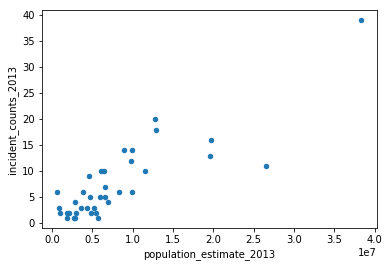

In [18]:
# extract 2013 population estimates
df_state_populations_2013 = df_state_populations[['Geography', 'Population Estimate (as of July 1) - 2013']]

df_state_populations_2013 = df_state_populations_2013.rename(index=str, columns={'Geography':'state', 'Population Estimate (as of July 1) - 2013':'population_estimate_2013'})
# merge number of incidents to population estimate (2013 only)
df_incidents_population_2013 = df_gun_violence_2013.merge(df_state_populations_2013, how='inner', on='state')
# plot results
df_incidents_population_2013.plot.scatter('population_estimate_2013', 'incident_counts_2013')

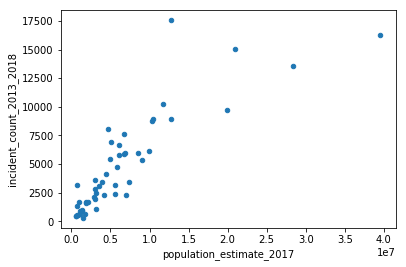

In [19]:
# now, let's combine incident counts for all years. We settle on population estimate for the year 2017
df_incident_count_2013_2018 = df_gun_violence['state'].value_counts().reset_index().rename(index=str, columns={'index':'state', 'state':'incident_count_2013_2018'})
df_state_populations_2017 = df_state_populations[['Geography','Population Estimate (as of July 1) - 2017']].rename(index=str, columns={'Geography':'state', 'Population Estimate (as of July 1) - 2017':'population_estimate_2017'})
df_incident_count_population_estimate_2017 = df_incident_count_2013_2018.merge(df_state_populations_2017, how='inner', left_on='state', right_on='state')
df_incident_count_population_estimate_2017.plot.scatter('population_estimate_2017', 'incident_count_2013_2018')

In [20]:
df_incident_count_population_estimate_2017.corr(method='pearson')

,incident_count_2013_2018,population_estimate_2017
incident_count_2013_2018,1.000000,0.853839
population_estimate_2017,0.853839,1.000000


#### Mass Shootings

In [21]:
# top ten states with most mass shootings from 2013 to 2018
df_gun_violence['mass_shooting'] = pd.to_numeric(df_gun_violence['incident_characteristics'].str.contains('Mass Shooting', case=False), downcast='integer')
df_gun_violence.loc[df_gun_violence['mass_shooting'] == 1.0]['state'].value_counts().head(10)

California      194
Illinois        151
Florida         116
Texas            97
New York         78
Georgia          69
Pennsylvania     65
Louisiana        63
Tennessee        62
Ohio             62
Name: state, dtype: int64

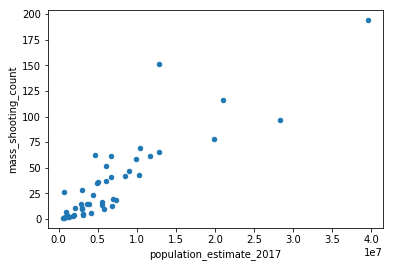

In [22]:
# population estimate vs. mass shooting count
df_gun_violence.loc[df_gun_violence['mass_shooting'] == 1.0]['state'].value_counts().reset_index().rename(index=str, columns={'index':'state', 'state':'mass_shooting_count'}).merge(df_state_populations_2017, how='inner', left_on='state', right_on='state').plot.scatter('population_estimate_2017', 'mass_shooting_count')

#### Home Invasion

In [23]:
# top ten states with most home invasions from 2013 to 2018
df_gun_violence['home_invasion'] = pd.to_numeric(df_gun_violence['incident_characteristics'].str.contains('Home Invasion', case=False), downcast='integer')
df_gun_violence.loc[df_gun_violence['home_invasion'] == 1.0]['state'].value_counts().head(10)

Florida           800
Texas             650
Georgia           578
North Carolina    558
California        483
Ohio              482
Pennsylvania      436
New York          420
Illinois          413
South Carolina    411
Name: state, dtype: int64

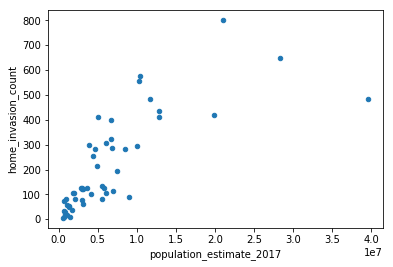

In [24]:
# population estimate vs. home invasion count
df_gun_violence.loc[df_gun_violence['home_invasion'] == 1.0]['state'].value_counts().reset_index().rename(index=str, columns={'index':'state', 'state':'home_invasion_count'}).merge(df_state_populations_2017, how='inner', left_on='state', right_on='state').plot.scatter('population_estimate_2017', 'home_invasion_count')

#### United States Regions

In [25]:
# Census regions of the United States (source: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)
northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'] 
midwest = ['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'] 
south = ['Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'] 
west = ['Arizona', 'Colorado', 'Idaho', 'New Mexico', 'Montana', 'Utah', 'Nevada', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']

In [26]:
# states in northeast region by number of incidents
df_gun_violence.loc[df_gun_violence['state'].isin(northeast)]['state'].value_counts()

New York         9712
Pennsylvania     8929
Massachusetts    5981
New Jersey       5387
Connecticut      3067
New Hampshire     964
Maine             907
Rhode Island      895
Vermont           472
Name: state, dtype: int64

In [27]:
# states in midwest region by number of incidents
df_gun_violence.loc[df_gun_violence['state'].isin(midwest)]['state'].value_counts()

Illinois        17556
Ohio            10244
Missouri         6631
Michigan         6136
Indiana          5852
Wisconsin        4787
Iowa             2517
Minnesota        2408
Kansas           2145
Nebraska         1651
North Dakota      573
South Dakota      544
Name: state, dtype: int64

In [28]:
# states in south region by number of incidents
df_gun_violence.loc[df_gun_violence['state'].isin(south)]['state'].value_counts()

Florida                 15029
Texas                   13577
Georgia                  8925
North Carolina           8739
Louisiana                8103
Tennessee                7626
South Carolina           6939
Virginia                 5949
Maryland                 5798
Alabama                  5471
Kentucky                 4157
Mississippi              3599
Oklahoma                 3455
District of Columbia     3195
Arkansas                 2842
Delaware                 1685
West Virginia            1575
Name: state, dtype: int64

In [29]:
# states in west region by number of incidents
df_gun_violence.loc[df_gun_violence['state'].isin(west)]['state'].value_counts()

California    16306
Washington     3434
Colorado       3201
Arizona        2328
Oregon         2286
Nevada         1952
New Mexico     1645
Alaska         1349
Utah           1072
Idaho           661
Montana         638
Wyoming         494
Hawaii          289
Name: state, dtype: int64

## Mean Income 2016 Analysis

In [30]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 1 columns):
size 2197    0 non-null object
dtypes: object(1)
memory usage: 0.0+ bytes


In [31]:
df_income.head()

,size 2197


In [32]:
# dropped US average income and 'Notes'
df_income.drop(df_income.index[0], inplace=True)
df_income.drop(df_income.index[52:], inplace=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df_income

In [ ]:
# renamed columns
# dropped '$' and convert from str to int
df_income = df_income.rename(index=str, columns={"Location":"state", "Median Annual Household Income": "median_annual_household_income_2016"})
df_income['median_annual_household_income_2016'] = pd.to_numeric(df_income['median_annual_household_income_2016'].str[1:], downcast='integer')
df_income

In [ ]:
# merged both dataframe(gun-violence && 2016_income)
df_gun_income = pd.merge(df_gun_violence, df_income, on="state", how="outer")
df_gun_income

In [ ]:
# merge incident count and mean income (mean annual income household 2016 only) per state
incident_count_per_state = df_gun_income['state'].value_counts().to_frame().reset_index().rename(index=str, columns={"index":"state", "state":"incident_count"})
state_incidentCount_medianIncome = pd.merge(incident_count_per_state, df_income, on="state", how="outer")
state_incidentCount_medianIncome


In [ ]:
# graphed (median_income && incident_count)
state_incidentCount_medianIncome.plot.scatter('median_annual_household_income_2016', 'incident_count')

## NRA Spending

In [33]:
# no null values 
df_nra_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
oid sha256:6fc5c80c52c20465e98c1a0f844c0f2bde50f1a13e4d29da9f7a622a32ff4678    1 non-null object
dtypes: object(1)
memory usage: 88.0+ bytes


In [34]:
df_nra_spending.head(10)

,oid sha256:6fc5c80c52c20465e98c1a0f844c0f2bde50f1a13e4d29da9f7a622a32ff4678
0,size 36798


In [ ]:
# From this dataset, we will attempt to correlate direct support, independent support, and grand total to
# number of incidents (separately)

In [ ]:
# convert monetary object of form '$d,ddd' to integer dddd
def convertToNumeric(string):
    numeric = ''
    for character in string:
        if character not in ['$', ',']:
            numeric += character
    return int(numeric)

# convert monetary values
df_nra_spending['nra_direct_support_numeric'] = df_nra_spending['NRA Direct Support'].apply(func=convertToNumeric)
df_nra_spending['nra_independent_support_numeric'] = df_nra_spending['NRA Independent Support'].apply(func=convertToNumeric)
df_nra_spending['nra_grand_total_numeric'] = df_nra_spending['NRA Grand Total'].apply(func=convertToNumeric)

# extract state code
df_nra_spending['Abbreviation'] = df_nra_spending['Distid'].str[0:2]

# extract significant columns
# Negative values for 'NRA Grand Total' mean that NRA likely opposes candidate
df_nra_spending_n = df_nra_spending.merge(df_state_codes, how='inner', left_on='Abbreviation', right_on='Abbreviation')[['First Race', 'State', 'Party', 'Office', 'nra_direct_support_numeric', 'nra_independent_support_numeric', 'nra_grand_total_numeric']].rename(index=str, columns={'First Race':'first_race', 'State':'state', 'Party':'party', 'Office':'office', 'nra_direct_support_numeric':'nra_direct_support', 'nra_independent_support_numeric':'nra_independent_support', 'nra_grand_total_numeric':'nra_grand_total'})

df_nra_spending_n.head()

#### NRA direct support (all candidates) vs. total number of incidents

In [ ]:
df_nra_direct_support_all_years = df_nra_spending_n.groupby(by='state')['nra_direct_support'].sum().reset_index()
df_incident_counts_2013_2018 = df_gun_violence['state'].value_counts().reset_index().rename(index=str, columns={'index':'state', 'state':'incident_count_2013_2018'})

df_nrads_ni = df_nra_direct_support_all_years.merge(df_incident_counts_2013_2018, how='inner', left_on='state', right_on='state')

df_nrads_ni.plot.scatter('nra_direct_support', 'incident_count_2013_2018')
df_nrads_ni.corr(method='pearson')

#### NRA independent support (all candidates) vs. total number of incidents

In [ ]:
df_nra_independent_support_all_years = df_nra_spending_n.groupby(by='state')['nra_independent_support'].sum().reset_index()

df_nrais_ni = df_nra_independent_support_all_years.merge(df_incident_counts_2013_2018, how='inner', left_on='state', right_on='state')

df_nrais_ni.plot.scatter('nra_independent_support', 'incident_count_2013_2018')
df_nrais_ni.corr(method='pearson')

#### NRA grand total (all candidates) vs. total number of incidents

In [ ]:
df_nra_grand_total_all_years = df_nra_spending_n.groupby(by='state')['nra_grand_total'].sum().reset_index()

df_nragt_ni = df_nra_grand_total_all_years.merge(df_incident_counts_2013_2018, how='inner', left_on='state', right_on='state')

df_nragt_ni.plot.scatter('nra_grand_total', 'incident_count_2013_2018')
df_nragt_ni.corr(method='pearson')

#### NRA direct support (all candidates whose first race >= 2013) vs. total number of incidents

In [ ]:
df_nra_direct_support_after_2013 = df_nra_spending_n.loc[df_nra_spending_n['first_race'] >= 2013].groupby(by='state')['nra_direct_support'].sum().reset_index()

df_nrads_ni_a2013 = df_nra_direct_support_after_2013.merge(df_incident_counts_2013_2018, how='inner', left_on='state', right_on='state')

df_nrads_ni_a2013.plot.scatter('nra_direct_support', 'incident_count_2013_2018')
df_nrads_ni_a2013.corr(method='pearson')

#### NRA independent support (all candidates whose first race >= 2013) vs. total number of incidents

In [ ]:
df_nra_independent_support_after_2013 = df_nra_spending_n.loc[df_nra_spending_n['first_race'] >= 2013].groupby(by='state')['nra_independent_support'].sum().reset_index()

df_nrais_ni_a2013 = df_nra_independent_support_after_2013.merge(df_incident_counts_2013_2018, how='inner', left_on='state', right_on='state')

df_nrais_ni_a2013.plot.scatter('nra_independent_support', 'incident_count_2013_2018')
df_nrais_ni_a2013.corr(method='pearson')

#### NRA grand total (all candidates whose first race >= 2013) vs. total number of incidents

In [ ]:
df_nra_grand_total_after_2013 = df_nra_spending_n.loc[df_nra_spending_n['first_race'] >= 2013].groupby(by='state')['nra_grand_total'].sum().reset_index()

df_nragt_ni_a2013 = df_nra_grand_total_after_2013.merge(df_incident_counts_2013_2018, how='inner', left_on='state', right_on='state')

df_nragt_ni_a2013.plot.scatter('nra_grand_total', 'incident_count_2013_2018')
df_nragt_ni_a2013.corr(method='pearson')